In [20]:
import cv2 as cv
import numpy as np
import pydicom as dicom
from matplotlib import pyplot as plt
import math

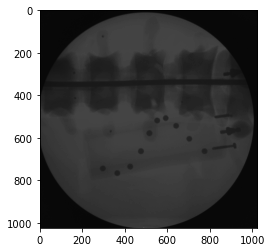

In [89]:
#reading image
I1 = dicom.dcmread('img1_1.DCM').pixel_array
plt.imshow(I1,'gray')

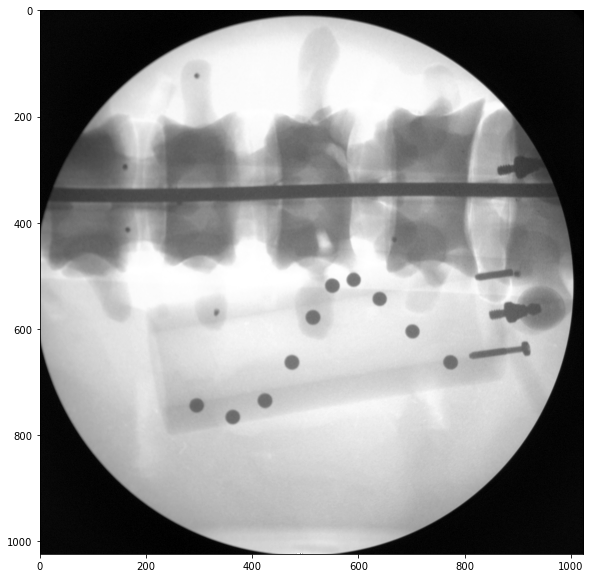

In [91]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(I1,cmap='gray',vmin=1700,vmax=16300)
plt.show()

In [80]:
I1.min(),I1.max()

(8, 60700)

In [81]:
I1.dtype

dtype('uint16')

In [82]:
size = np.shape(I1)

In [94]:
import bisect

def imadjust(src, tol=1, vin=[0,65535], vout=(0,65535)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))   
    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(65536)),range=(0,65535))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(0, 65535): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_right(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

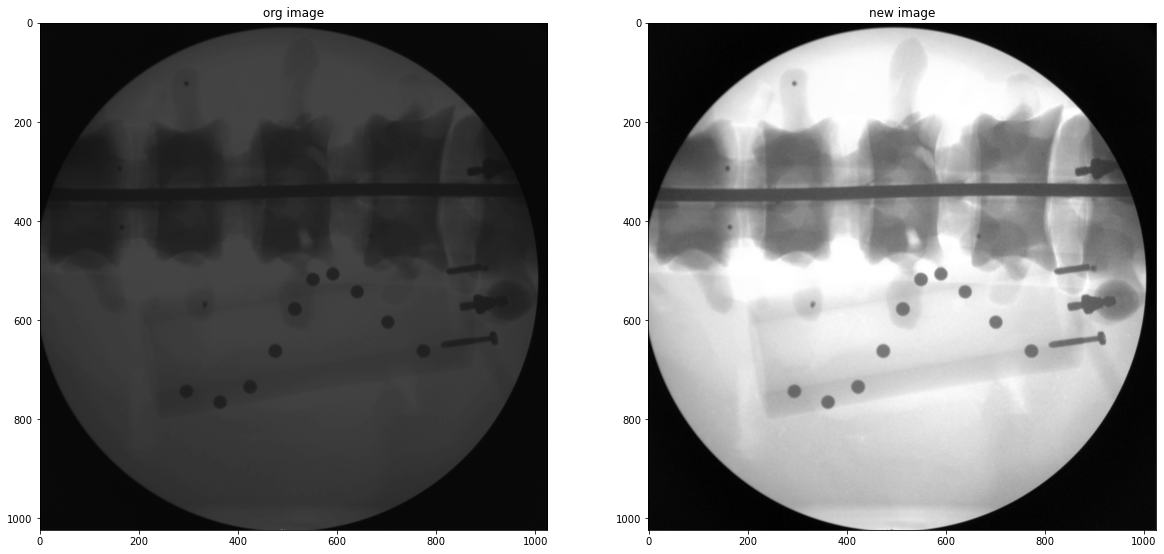

In [95]:
out=imadjust(I1)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(im1,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(out,cmap = 'gray')
plt.show()

In [87]:
out.min(),out.max()

(0.5, 65535.0)

(1024, 1024)

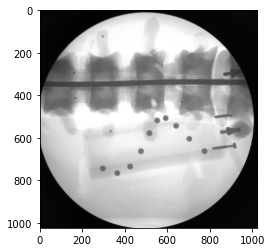

In [85]:
adjusted = cv.imread('adjustedimage1.png',0)
plt.imshow(adjusted,'gray')
np.shape(adjusted)

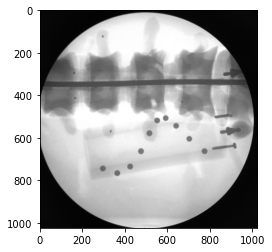

In [68]:
plt.imshow(out,'gray')

In [77]:
adjusted.dtype

dtype('uint8')

In [40]:
def stretchlim(img):
    #defining tolerance 
    tol_low = 0.01
    tol_high = 0.99
    
    # Determine size of image in pixels
    sz = np.shape(img)
    num_of_px = sz[0]*sz[1]
    
    # Determine one percent of total pixels (for use in image adjust code)
    one_perc = math.floor(num_of_px*0.01)
    lims = np.zeros((1,2))
    # Compute lower/upper 1% threshold for each channel
    for i in range(0,1):
        hist,bins = np.histogram(img[:,:,i].ravel(),255,[0,255])
        val = 0; j = 0;
        while val < one_perc:
            val = val+hist[j]
            j = j +1
        lims[i,0] = j
        val = 0; j = 0;
        while val < one_perc:
            val = val+hist[254-j]
            j = j + 1
        lims[i,1] = 254-j
    return lims